In [1]:
import cv2
import pyautogui

import numpy as np  
import mediapipe as mp  

import matplotlib.pyplot as plt 

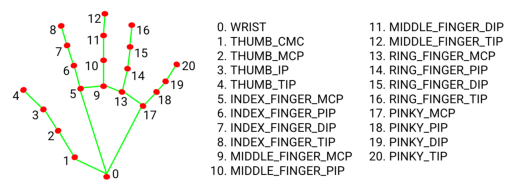

In [ ]:
image = cv2.imread('C:/Users/PC/Deskop/Hand_Landmark_by_Mediapipe/assert/hand_landmarks.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')     
plt.show()  

In [ ]:
def check_finger_state(hand_landmarks, tip_idx, pip_idx, image_width):
    """
    Kiểm tra trạng thái duỗi/gập của một ngón tay
    tip_idx: chỉ số của đầu ngón
    pip_idx: chỉ số của khớp thứ nhất (PIP)
    Return: True nếu ngón duỗi ra, False nếu ngón gập lại
    """
    tip_x = hand_landmarks.landmark[tip_idx].x * image_width
    pip_x = hand_landmarks.landmark[pip_idx].x * image_width
    # So sánh vị trí x của đầu ngón với khớp PIP
    # Nếu đầu ngón ở xa hơn so với khớp PIP, ngón tay được coi là duỗi ra
    return abs(tip_x - pip_x) > 30  # Có thể điều chỉnh ngưỡng này

In [ ]:
def is_index_pointing(hand_landmarks, image_width):
    """
    Kiểm tra xem có phải cử chỉ ngón trỏ duỗi ra, các ngón khác gập lại không
    """
    # Kiểm tra ngón trỏ có duỗi ra không
    index_extended = check_finger_state(hand_landmarks, 8, 6, image_width)
    
    # Kiểm tra các ngón khác có gập lại không
    middle_folded = not check_finger_state(hand_landmarks, 12, 10, image_width)
    ring_folded = not check_finger_state(hand_landmarks, 16, 14, image_width)
    pinky_folded = not check_finger_state(hand_landmarks, 20, 18, image_width)
    
    # Trả về True chỉ khi ngón trỏ duỗi ra và các ngón khác gập lại
    return index_extended and middle_folded and ring_folded and pinky_folded

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands()
pyautogui.FAILSAFE = False


# Bắt đầu webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        continue

    # Xử lý hình ảnh với MediaPipe
    image = cv2.flip(image, 1)  # Lật ngang hình ảnh để dễ nhìn hơn
    image.flags.writeable = False
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    # Vẽ landmarks và tọa độ
    image.flags.writeable = True
    image_height, image_width, _ = image.shape
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Vẽ các đường nối giữa các điểm
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )
            
            # Kiểm tra cử chỉ ngón trỏ
            if is_index_pointing(hand_landmarks, image_width):
                gesture_text = "Index Finger Pointing!"
                color = (0, 255, 0)  # Màu xanh lá
            else:
                gesture_text = "No gesture"
                color = (0, 0, 255)  # Màu đỏ
                
            # Hiển thị trạng thái cử chỉ
            cv2.putText(image, gesture_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            # Vẽ tọa độ cho từng điểm
            for idx, landmark in enumerate(hand_landmarks.landmark):
                x = int(landmark.x * image_width)
                y = int(landmark.y * image_height)
                cv2.circle(image, (x, y), 3, (0, 0, 255), -1)
                coord_text = f"{idx}:({x},{y})"
                cv2.putText(image, coord_text, (x+5, y-5), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # Hiển thị hình ảnh
    cv2.imshow("Hand Gesture Detection", image)
    
    if cv2.waitKey(5) & 0xFF == 27:  # Nhấn Esc để thoát
        break

cap.release()
cv2.destroyAllWindows()